In [60]:
hd_dir = "/home/hpc/cudahub/tracer/hybriddomain/"
modelFileName = 'problems/ur_zap4'
conn_name = "dglconnection"
device_conf_name = "dgllogisticdevices"


In [61]:
import os
import sys
import inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
if hd_dir not in sys.path:
    sys.path.insert(0, hd_dir)
env_dir = os.path.join(hd_dir, 'spaces', 'math_space', "common")
if env_dir not in sys.path:
    sys.path.insert(0, env_dir)
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from envs.hs.model.model_main import ModelNet as Model
from settings.settings_main import Settings

In [62]:
model = Model()
model.io.loadFromFile(modelFileName)
settings = Settings(model, conn_name, device_conf_name, conn_name, pf_prefix=currentdir)

INFO:block_main.block_io:DefaultBound not set
INFO:settings_main:device_conf_name
INFO:settings_main:dgllogisticdevices


Please enter password for user hpc:
········


In [63]:
#block0 = model.blocks[0]
#equation = model.equations[0]
#model.paramValues

In [64]:
from solvers.hs.remoterun.progresses.progress_notebook import ProgressNotebook
progress = ProgressNotebook(100, prefix='solving')
from solvers.hs.remoterun.remoterun import remoteProjectRun

clear_output()
test_name = settings.paths['model']['name']
bTest = widgets.Button(description="run %s " % (test_name))
def run(event):
    
    remoteProjectRun(settings, 1, progress)
bTest.on_click(run)
display(progress.progress)
display(bTest)

IntProgress(value=0, description='solving: ', max=99)

Button(description='run ur_zap4 ', style=ButtonStyle())

INFO:remoterun:project_path
INFO:remoterun:ur_zap4
INFO:remoterun:project_name
INFO:remoterun:ur_zap4
INFO:paramiko.transport:Connected (version 2.0, client OpenSSH_7.2)
INFO:paramiko.transport:Authentication (publickey) successful!
INFO:remoterun:Checking if folder /home/hpc/Tracer/dglprojects exists...
INFO:remoterun:Workspace OK.
INFO:remoterun:Creating/cleaning project folder: 
INFO:remoterun:Folder cleaned.
INFO:remoterun:Creating settings folders: 
INFO:remoterun:Checking if folder /home/hpc/Tracer/dglprojects/settings exists...
INFO:remoterun:folder /home/hpc/Tracer/dglprojects/settings alredy exist
INFO:remoterun:Checking if folder /home/hpc/Tracer/dglprojects/settings/paths exists...
INFO:remoterun:folder /home/hpc/Tracer/dglprojects/settings/paths alredy exist
INFO:remoterun:Checking if folder /home/hpc/Tracer/dglprojects/settings/device_conf exists...
INFO:remoterun:folder /home/hpc/Tracer/dglprojects/settings/device_conf alredy exist
INFO:remoterun:settings folders created


### Results:

In [65]:
import numpy as np
import re

import matplotlib.pyplot as plt
from ipywidgets import interactive


out_dir = os.path.join(currentdir,  modelFileName, "out")
listdir = os.listdir(out_dir)

print(listdir)

outs = [os.path.join(out_dir, file_name)
        for file_name in listdir
        if '.out' in file_name]
print(outs)
#with open(outs[0]) as f:
#    data = f.read()

['.ipynb_checkpoints', 'ur_zap4-plot0.mp4', 'ur_zap4-res0-U.out']
['/home/hpc/cudahub/tracer/hybriddomain/tests/ur_zap_test4/problems/ur_zap4/out/ur_zap4-res0-U.out']


In [66]:
#Эта функция выбирает из какого файла вытаскивать данные в папке out

def vibor(i):
    outs = [os.path.join(out_dir, file_name)
        for file_name in listdir
        if '.out' in file_name]
    with open(outs[i]) as f:
        data = f.read()
    lines = data.split('\n')
    result = {}

    for line in lines:
        if ':' in line:
            key, val = line.split(':')
            result[key]=val[1:]
        else:
            val = line
            result[key] += val  
    return key, val, result

In [67]:
#более не требуется
#lines = data.split('\n')
#result = {}

#for line in lines:
#    if ':' in line:
#        key, val = line.split(':')
#        result[key]=val[1:]
#    else:
#        val = line
#        result[key] += val
        

In [68]:
def gen(reuslt):
    for key in reuslt:
        step_0 = re.subn(r'\.\s+',".0,",result[key])[0]
        step_1 = re.subn(r'\s+',",",step_0)[0]
        step_2 = step_1.replace('.]','.0]')
        step_3 = step_2.replace('[,','[')

        yield((key, eval(step_3)))

In [69]:

key, val, result = vibor(0)
result_t = dict([(float(key), val) for key, val in gen(result)])
#print(result_t)
time = [key for key in result_t]
result_x = np.array([result_t[key] for key in result_t]).T


##это если система из более чем одного уравнения выбирается строка результата
#key, val, result = vibor(1)
#result_t = dict([(float(key), val) for key, val in gen(result)])
#result_y = np.array([result_t[key] for key in result_t]).T
##print (result_x)
#print(len(result_x[0]))
##print (result_x)
##print (result_y)

##### U(x, t-fixed):

In [70]:
%matplotlib inline
def f(t):
    plt.plot(result_t[time[t]])
w = interactive(f,t=(0,100,1))
display(w)

interactive(children=(IntSlider(value=50, description='t'), Output()), _dom_classes=('widget-interact',))

In [71]:
"""
This module implements ddeint, a simple Differential Delay Equation
solver built on top of Scipy's odeint """

# REQUIRES Numpy and Scipy.
import numpy as np
import scipy.integrate
import scipy.interpolate


class ddeVar:
    """
    The instances of this class are special function-like
    variables which store their past values in an interpolator and
    can be called for any past time: Y(t), Y(t-d).
    Very convenient for the integration of DDEs.
    """

    def __init__(self, g, tc=0):
        """ g(t) = expression of Y(t) for t<tc """

        self.g = g
        self.tc = tc
        # We must fill the interpolator with 2 points minimum
        self.itpr = scipy.interpolate.interp1d(
            np.array([tc - 1, tc]),  # X
            np.array([self.g(tc), self.g(tc)]).T,  # Y
            kind='linear', bounds_error=False,
            fill_value=self.g(tc))

    def update(self, t, Y):
        """ Add one new (ti,yi) to the interpolator """

        self.itpr.x = np.hstack([self.itpr.x, [t]])
        Y2 = Y if (Y.size == 1) else np.array([Y]).T
        self.itpr.y = np.hstack([self.itpr.y, Y2])
        self.itpr.fill_value = Y
        self.itpr._y = self.itpr._reshape_yi(self.itpr.y)

    def __call__(self, t=0):
        """ Y(t) will return the instance's value at time t """

        return (self.g(t) if (t <= self.tc) else self.itpr(t))


class dde(scipy.integrate.ode):
    """
    This class overwrites a few functions of ``scipy.integrate.ode``
    to allow for updates of the pseudo-variable Y between each
    integration step.
    """

    def __init__(self, f, jac=None):
        def f2(t, y, args):
            return f(self.Y, t, *args)

        scipy.integrate.ode.__init__(self, f2, jac)
        self.set_f_params(None)

    def integrate(self, t, step=0, relax=0):
        scipy.integrate.ode.integrate(self, t, step, relax)
        self.Y.update(self.t, self.y)
        return self.y

    def set_initial_value(self, Y):
        self.Y = Y  # !!! Y will be modified during integration
        scipy.integrate.ode.set_initial_value(self, Y(Y.tc), Y.tc)


def ddeint(func, g, tt, fargs=None):
    """ Solves Delay Differential Equations
    Similar to scipy.integrate.odeint. Solves a Delay differential
    Equation system (DDE) defined by
        Y(t) = g(t) for t<0
        Y'(t) = func(Y,t) for t>= 0
    Where func can involve past values of Y, like Y(t-d).

    Parameters
    -----------

    func
      a function Y,t,args -> Y'(t), where args is optional.
      The variable Y is an instance of class ddeVar, which means that
      it is called like a function: Y(t), Y(t-d), etc. Y(t) returns
      either a number or a numpy array (for multivariate systems).
    g
      The 'history function'. A function g(t)=Y(t) for t<0, g(t)
      returns either a number or a numpy array (for multivariate
      systems).

    tt
      The vector of times [t0, t1, ...] at which the system must
      be solved.
    fargs
      Additional arguments to be passed to parameter ``func``, if any.
    Examples
    ---------

    We will solve the delayed Lotka-Volterra system defined as

        For t < 0:
        x(t) = 1+t
        y(t) = 2-t

        For t >= 0:
        dx/dt =  0.5* ( 1- y(t-d) )
        dy/dt = -0.5* ( 1- x(t-d) )

    The delay ``d`` is a tunable parameter of the model.
    >>> import numpy as np
    >>> from ddeint import ddeint
    >>>
    >>> def model(XY,t,d):
    >>>     x, y = XY(t)
    >>>     xd, yd = XY(t-d)
    >>>     return np.array([0.5*x*(1-yd), -0.5*y*(1-xd)])
    >>>
    >>> g = lambda t : np.array([1+t,2-t]) # 'history' at t<0
    >>> tt = np.linspace(0,30,20000) # times for integration
    >>> d = 0.5 # set parameter d
    >>> yy = ddeint(model,g,tt,fargs=(d,)) # solve the DDE !

    """

    dde_ = dde(func)
    dde_.set_initial_value(ddeVar(g, tt[0]))
    dde_.set_f_params(fargs if fargs else [])
    results = [dde_.integrate(dde_.t + dt) for dt in np.diff(tt)]
    return np.array([g(tt[0])] + results)

##### U(x-fixed, t):

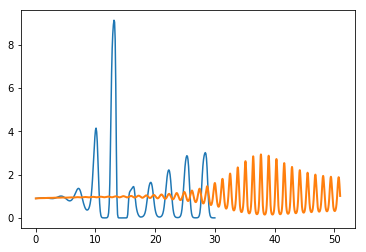

302
101


In [72]:
#уравнение численности насекомых 
%matplotlib inline

#from pylab import *
import math

#Синяя линия сама траектория
plt.plot(time,result_x[10])

#
#def model(Y,t,d):
#    x,y=Y(t)
#    return np.array([2*x-1*x*y,-2*y+1*x*y])

#g=lambda t : np.array ([4.0,1.0])

#количество точек для использования построения решения
#tt =np.linspace (0.0,10.0,10000)
#
#for d in [0,0.2]:
#    yy2 = ddeint (model,g,tt,fargs=(d,))
#оранджевое это то что рисует библиотечный метод по своей сетке tt
#plt.plot(yy2[:,0],yy2[:,1],lw=2)




k = 2
h = 0.3
r = 3.0
a = 0.9
model = lambda Y,t, k,h,r :  r * (1 -a*(1-Y(t-1))-  Y(t-h)) * Y(t)
g = lambda t: 0.9 # history before t=0

tt = np.linspace(0,51,51000)
yy = ddeint(model, g, tt, fargs=(k, h, r)) # K=0.1, d=5, r=1

plt.plot(tt, yy, lw=2)





plt.show()
print(len(result_x[10]))
print(len(result_x))
